# AI-Powered URL Phishing Detection System
# Deep Random Forest Classifier for Chatbot

## Steup and Imports

In [1]:
!pip install python-whois dnspython tldextract beautifulsoup4 requests pyOpenSSL tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import os
import re
import requests
import socket
from urllib.parse import urlparse
from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import whois
import dns.resolver
import tldextract
import ssl
import OpenSSL.crypto as crypto
import concurrent.futures
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration and Logging

### Set up logging

In [4]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [5]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/chatbot/chatbot_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_metadata.json'
FEATURES_OUTPUT_PATH = f'{BASE_PATH}/models/chatbot/chatbot_features.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/chatbot_training_log.json'

### Create directories if they don't exist

In [6]:
os.makedirs(f'{BASE_PATH}/data/processed', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models/gradient_boosting_model', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Load and explore the dataset

### Load dataset

In [7]:
log_event("DATA_LOADING", "Loading dataset")
start_time = time.time()

[2025-04-29T12:32:56.139991] DATA_LOADING: Loading dataset


In [8]:
try:
    df = pd.read_csv(RAW_DATA_PATH)
    # Ensure class column is properly named and has numeric values
    if 'label' in df.columns:
        df = df.rename(columns={'label': 'class'})

    if df['class'].dtype == 'object':
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Class distribution: {df['class'].value_counts().to_dict()}")

    log_event("DATA_LOADED", f"Dataset loaded with shape {df.shape}")
except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

Dataset loaded with 4000 rows and 2 columns
Class distribution: {1: 2000, 0: 2000}
[2025-04-29T12:32:57.915394] DATA_LOADED: Dataset loaded with shape (4000, 2)


In [9]:
loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-04-29T12:33:00.328968] TIMING: Data loading completed in 4.19 seconds


### Display basic information

In [10]:
print("Dataset Information:")
print(f"Total samples: {df.shape[0]}")
print(f"Features: {df.shape[1]}")
print("\nData Types:")
print(df.dtypes)
print("\nClass Distribution:")
print(df['class'].value_counts())
print("\nFirst 5 rows:")
print(df.head())

Dataset Information:
Total samples: 4000
Features: 2

Data Types:
URL      object
class     int64
dtype: object

Class Distribution:
class
1    2000
0    2000
Name: count, dtype: int64

First 5 rows:
                                            URL  class
0  https://start-support-tizer.gitbook.io/en-us      1
1       https://iieudsjwasndjfkdjdd.weebly.com/      1
2           https://0x-turbos.pages.dev/wallets      1
3                   https://shbox.top/yecunoeu/      1
4            https://sparkflrdrops.xyz/clm.html      1


## 2. Feature Extraction Functions

In [11]:
log_event("FEATURE_EXTRACTION_FUNCTIONS", "Extracting functions for chatbot deep analysis")
start_time = time.time()

[2025-04-29T12:33:04.015903] FEATURE_EXTRACTION_FUNCTIONS: Extracting functions for chatbot deep analysis


Extract comprehensive features for deep analysis in the chatbot based on the specified list:
  - UsingIP
  - LongURL
  - ShortURL
  - Symbol@
  - Redirecting//
  - PrefixSuffix-
  - SubDomains
  - HTTPS
  - DomainRegLen
  - Favicon
  - NonStdPort
  - HTTPSDomainURL
  - RequestURL
  - AnchorURL
  - LinksInScriptTags
  - ServerFormHandler
  - InfoEmail
  - AbnormalURL
  - WebsiteForwarding
  - StatusBarCust
  - DisableRightClick
  - UsingPopupWindow
  - IframeRedirection
  - AgeofDomain
  - DNSRecording
  - WebsiteTraffic
  - PageRank
  - GoogleIndex
  - LinksPointingToPage
  - StatsReport

### URL Parsing

In [12]:
def get_domain(url):
    """Extract domain from URL"""
    try:
        extracted = tldextract.extract(url)
        domain = f"{extracted.domain}.{extracted.suffix}"
        if extracted.subdomain:
            full_domain = f"{extracted.subdomain}.{domain}"
        else:
            full_domain = domain
        return domain, full_domain
    except:
        return None, None

### WHOIS Information

In [13]:
def get_domain_info(domain):
    """Get domain registration info using WHOIS"""
    try:
        w = whois.whois(domain)

        # Get creation date
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]

        # Get expiration date
        expiration_date = w.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]

        # Calculate age in days
        if creation_date:
            domain_age = (datetime.now() - creation_date).days
        else:
            domain_age = -1

        # Calculate registration length in days
        if creation_date and expiration_date:
            reg_len = (expiration_date - creation_date).days
        else:
            reg_len = -1

        return {
            'domain_age': domain_age,
            'registration_length': reg_len
        }
    except Exception as e:
        return {
            'domain_age': -1,
            'registration_length': -1
        }

### DNS Records

In [14]:
def get_dns_records(domain):
    """Check if domain has proper DNS records"""
    records = {
        'has_a': False,
        'has_mx': False,
        'has_ns': False,
        'has_txt': False,
        'total_records': 0
    }

    try:
        # A record
        try:
            answers = dns.resolver.resolve(domain, 'A')
            records['has_a'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # MX record
        try:
            answers = dns.resolver.resolve(domain, 'MX')
            records['has_mx'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # NS record
        try:
            answers = dns.resolver.resolve(domain, 'NS')
            records['has_ns'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        # TXT record
        try:
            answers = dns.resolver.resolve(domain, 'TXT')
            records['has_txt'] = len(answers) > 0
            records['total_records'] += len(answers)
        except:
            pass

        return records
    except Exception as e:
        return records

### HTML Content Analysis

In [15]:
def analyze_html_content(url):
    """Analyze HTML content for suspicious patterns"""
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }
        response = requests.get(url, headers=headers, timeout=5)

        if response.status_code != 200:
            return get_default_html_features()

        soup = BeautifulSoup(response.text, 'html.parser')
        domain, full_domain = get_domain(url)

        # Check favicon
        favicon = soup.find('link', rel=lambda r: r and 'icon' in r.lower())
        has_favicon = favicon is not None
        external_favicon = False
        if has_favicon and favicon.get('href'):
            favicon_url = favicon['href']
            if not favicon_url.startswith('data:'):
                if favicon_url.startswith('http'):
                    favicon_domain = get_domain(favicon_url)[0]
                    external_favicon = favicon_domain != domain

        # Check forms
        forms = soup.find_all('form')
        form_action_external = False
        for form in forms:
            action = form.get('action', '')
            if action and action.startswith('http'):
                action_domain = get_domain(action)[0]
                if action_domain != domain:
                    form_action_external = True
                    break

        # Check for password fields
        has_password_field = len(soup.find_all('input', type='password')) > 0

        # Check for hidden elements
        has_hidden_element = len(soup.find_all('input', type='hidden')) > 0

        # Count scripts from external domains
        scripts = soup.find_all('script', src=True)
        external_scripts = 0
        for script in scripts:
            if script['src'].startswith('http'):
                script_domain = get_domain(script['src'])[0]
                if script_domain != domain:
                    external_scripts += 1

        # Count iframes
        iframe_count = len(soup.find_all('iframe'))

        # Count onclick events
        elements_with_onclick = soup.find_all(lambda tag: tag.has_attr('onclick'))
        onclick_count = len(elements_with_onclick)

        # Analyze links
        links = soup.find_all('a', href=True)
        external_links = 0
        internal_links = 0
        null_links = 0

        for link in links:
            href = link['href'].lower()
            if href == '#' or href == 'javascript:void(0)':
                null_links += 1
            elif href.startswith('http'):
                link_domain = get_domain(href)[0]
                if link_domain != domain:
                    external_links += 1
                else:
                    internal_links += 1
            else:
                internal_links += 1

        # Check for right-click disabling
        has_right_click_disabled = 'oncontextmenu="return false"' in response.text or 'event.button==2' in response.text

        # Check for popups
        has_popup = 'window.open(' in response.text

        # Check for status bar customization
        status_bar_customized = 'window.status' in response.text

        return {
            'has_favicon': has_favicon,
            'external_favicon': external_favicon,
            'form_action_external': form_action_external,
            'has_password_field': has_password_field,
            'has_hidden_element': has_hidden_element,
            'external_scripts': external_scripts,
            'iframe_count': iframe_count,
            'onclick_count': onclick_count,
            'external_links': external_links,
            'internal_links': internal_links,
            'null_links': null_links,
            'has_right_click_disabled': has_right_click_disabled,
            'has_popup': has_popup,
            'status_bar_customized': status_bar_customized
        }
    except Exception as e:
        return get_default_html_features()

In [16]:
def get_default_html_features():
    """Return default HTML features"""
    return {
        'has_favicon': False,
        'external_favicon': False,
        'form_action_external': False,
        'has_password_field': False,
        'has_hidden_element': False,
        'external_scripts': 0,
        'iframe_count': 0,
        'onclick_count': 0,
        'external_links': 0,
        'internal_links': 0,
        'null_links': 0,
        'has_right_click_disabled': False,
        'has_popup': False,
        'status_bar_customized': False
    }

### Parallel feature extraction

In [17]:
def extract_url_features(url):
    """Extract all features for a single URL"""
    # Basic URL features
    features = {}

    # --- URL STRUCTURE FEATURES ---
    # Check if URL uses IP address
    features['UsingIP'] = 1 if bool(re.search(r'\d+\.\d+\.\d+\.\d+', url)) else 0

    # URL length
    features['LongURL'] = 1 if len(url) > 75 else 0

    # Check for URL shortening services
    url_shorteners = ['bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'is.gd', 'cli.gs', 'ow.ly', 'tiny.cc', 'shorte.st']
    features['ShortURL'] = 1 if any(shortener in url for shortener in url_shorteners) else 0

    # Check for @ symbol
    features['Symbol@'] = 1 if '@' in url else 0

    # Check for multiple forward slashes
    features['Redirecting//'] = 1 if url.replace('https://', '').replace('http://', '').find('//') != -1 else 0

    # --- DOMAIN FEATURES ---
    # Extract domain information
    domain, full_domain = get_domain(url)

    if not domain:
        # If domain extraction failed, return basic features with default values
        return get_default_features()

    # Check for hyphen in domain
    features['PrefixSuffix-'] = 1 if '-' in domain else 0

    # Count subdomains
    extracted = tldextract.extract(url)
    features['SubDomains'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0

    # --- PROTOCOL FEATURES ---
    # CRITICAL CHANGE: uses_http (1 means HTTP, less secure), (0 means HTTPS, more secure)
    features['uses_http'] = 0 if url.startswith('https') else 1

    # --- DOMAIN REPUTATION FEATURES ---
    # Domain length (shorter domains are usually more legitimate)
    features['DomainLength'] = 1 if len(domain) > 20 else 0

    # Top-level domain type
    suspicious_tlds = ['.xyz', '.info', '.online', '.site', '.top', '.club', '.work']
    features['SuspiciousTLD'] = 1 if any(tld in domain for tld in suspicious_tlds) else 0

    # --- WHOIS INFORMATION ---
    whois_info = get_domain_info(domain)
    features['DomainRegLen'] = 1 if whois_info['registration_length'] > 365 else 0
    features['AgeofDomain'] = 1 if whois_info['domain_age'] > 180 else 0

    # --- URL PATH FEATURES ---
    parsed_url = urlparse(url)

    # Check for non-standard port
    port = parsed_url.port
    features['NonStdPort'] = 1 if port and port not in [80, 443] else 0

    # Path depth
    path_elements = parsed_url.path.split('/')
    features['PathDepth'] = 1 if len([p for p in path_elements if p]) >= 3 else 0

    # Query parameters
    features['NumParams'] = 1 if len(parsed_url.query.split('&')) > 2 else 0

    # Check if 'https' appears in domain part (misleading practice)
    features['HTTPSDomainURL'] = 1 if 'https' in domain or 'http' in domain else 0

    # --- SUSPICIOUS CONTENT FEATURES ---
    # Check for suspicious terms in URL
    suspicious_terms = ['login', 'signin', 'verify', 'account', 'security', 'update', 'confirm', 'payment']
    features['AbnormalURL'] = 1 if any(term in url.lower() for term in suspicious_terms) else 0

    # Check for email-related terms
    features['InfoEmail'] = 1 if any(term in url.lower() for term in ['mail', 'email', 'contact']) else 0

    # --- DNS FEATURES ---
    dns_info = get_dns_records(domain)
    features['DNSRecording'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Website popularity estimation (based on DNS records as a proxy)
    features['WebsiteTraffic'] = 1 if dns_info['total_records'] > 3 else 0
    features['PageRank'] = 1 if dns_info['has_a'] and dns_info['has_mx'] and dns_info['has_ns'] else 0
    features['GoogleIndex'] = 1 if dns_info['has_a'] and dns_info['has_ns'] else 0

    # Links pointing to the page (estimate based on domain age)
    features['LinksPointingToPage'] = 1 if whois_info['domain_age'] > 365 else 0

    # Stats report availability
    features['StatsReport'] = 1 if whois_info['domain_age'] > 180 and dns_info['total_records'] > 3 else 0

    # --- HTML CONTENT ANALYSIS ---
    # Only attempt for URLs that use HTTP/HTTPS
    if url.startswith('http'):
        try:
            html_info = analyze_html_content(url)

            # Favicon from different domain
            features['Favicon'] = 1 if html_info['external_favicon'] else 0

            # External request URLs
            features['RequestURL'] = 1 if html_info['external_scripts'] > 0 else 0

            # External anchor URLs
            features['AnchorURL'] = 1 if html_info['external_links'] > html_info['internal_links'] else 0

            # Links in script tags
            features['LinksInScriptTags'] = 1 if html_info['external_scripts'] > 2 else 0

            # Server form handler
            features['ServerFormHandler'] = 1 if html_info['form_action_external'] else 0

            # Website forwarding
            features['WebsiteForwarding'] = 1 if html_info['null_links'] > 3 else 0

            # Status bar customization
            features['StatusBarCust'] = 1 if html_info['status_bar_customized'] else 0

            # Right-click disabled
            features['DisableRightClick'] = 1 if html_info['has_right_click_disabled'] else 0

            # Popup windows
            features['UsingPopupWindow'] = 1 if html_info['has_popup'] else 0

            # Iframe redirection
            features['IframeRedirection'] = 1 if html_info['iframe_count'] > 0 else 0

        except Exception as e:
            # Default values for HTML features if analysis fails
            set_default_html_features(features)
    else:
        # Default values for HTML features for non-HTTP URLs
        set_default_html_features(features)

    return features

### Helper function for default features

In [18]:
def get_default_features():
    """Return default feature set with zeros"""
    return {
        'UsingIP': 0, 'LongURL': 0, 'ShortURL': 0, 'Symbol@': 0,
        'Redirecting//': 0, 'PrefixSuffix-': 0, 'SubDomains': 0,
        'uses_http': 0, 'DomainRegLen': 0, 'Favicon': 0, 'NonStdPort': 0,
        'HTTPSDomainURL': 0, 'RequestURL': 0, 'AnchorURL': 0,
        'LinksInScriptTags': 0, 'ServerFormHandler': 0, 'InfoEmail': 0,
        'AbnormalURL': 0, 'WebsiteForwarding': 0, 'StatusBarCust': 0,
        'DisableRightClick': 0, 'UsingPopupWindow': 0, 'IframeRedirection': 0,
        'AgeofDomain': 0, 'DNSRecording': 0, 'WebsiteTraffic': 0,
        'PageRank': 0, 'GoogleIndex': 0, 'LinksPointingToPage': 0,
        'StatsReport': 0, 'DomainLength': 0, 'SuspiciousTLD': 0,
        'PathDepth': 0, 'NumParams': 0
    }

### Helper function for setting default HTML features

In [19]:
def set_default_html_features(features):
    """Set default HTML features"""
    features['Favicon'] = 0
    features['RequestURL'] = 0
    features['AnchorURL'] = 0
    features['LinksInScriptTags'] = 0
    features['ServerFormHandler'] = 0
    features['WebsiteForwarding'] = 0
    features['StatusBarCust'] = 0
    features['DisableRightClick'] = 0
    features['UsingPopupWindow'] = 0
    features['IframeRedirection'] = 0

In [20]:
log_event("TIMING", "Feature extraction functions defined")

[2025-04-29T12:33:25.406313] TIMING: Feature extraction functions defined


## 3. Feature Extraction with Parallelization

In [21]:
log_event("FEATURE_EXTRACTION", "Starting comprehensive feature extraction for chatbot model")

[2025-04-29T12:33:26.704346] FEATURE_EXTRACTION: Starting comprehensive feature extraction for chatbot model


### Empty features DataFrame

In [22]:
empty_features = get_default_features()

In [23]:
batch_size = 50
url_list = df['URL'].tolist()
url_to_class = dict(zip(df['URL'], df['class']))

# Initialize containers
all_results = []
all_classes = []

In [24]:
log_event("FEATURE_EXTRACTION", f"Processing {len(url_list)} URLs in batches of {batch_size}")

[2025-04-29T12:33:42.656717] FEATURE_EXTRACTION: Processing 4000 URLs in batches of 50


In [25]:
with ThreadPoolExecutor(max_workers=16) as executor:
    for i in tqdm(range(0, len(url_list), batch_size)):
        batch = url_list[i:i+batch_size]

        # Keep track of the correct classes for this batch
        batch_classes = [url_to_class[url] for url in batch]

        future_to_url = {executor.submit(extract_url_features, url): url for url in batch}

        batch_results = []
        batch_processed_classes = []

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                features = future.result()
                batch_results.append(features)
                batch_processed_classes.append(url_to_class[url])
            except Exception as e:
                log_event("ERROR", f"Failed to extract features for URL: {url[:50]}... - {str(e)}")
                batch_results.append(empty_features.copy())
                batch_processed_classes.append(url_to_class[url])

        all_results.extend(batch_results)
        all_classes.extend(batch_processed_classes)

  0%|          | 0/80 [00:00<?, ?it/s]

2025-04-29 12:33:45,515 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 12:33:46,736 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 12:34:18,217 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 12:34:18,219 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno -2] Name or service not known
2025-04-29 12:34:18,219 

### Create DataFrame from results

In [26]:
features_df = pd.DataFrame(all_results)
features_df['is_phishing'] = all_classes

### Handle any potential numeric issues

In [27]:
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(0)

### Save processed features

In [28]:
features_df.to_csv(PROCESSED_DATA_PATH, index=False)

In [29]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": features_df.shape[1] - 1})

[2025-04-29T12:59:18.307302] TIMING: Feature extraction completed in 1574.29 seconds


## 4. Feature Analysis

In [30]:
print("\nExtracted Features Summary:")
print(features_df.describe())


Extracted Features Summary:
           UsingIP      LongURL    ShortURL     Symbol@  Redirecting//  \
count  4000.000000  4000.000000  4000.00000  4000.00000         4000.0   
mean      0.003000     0.115250     0.08225     0.00375            0.0   
std       0.054697     0.319363     0.27478     0.06113            0.0   
min       0.000000     0.000000     0.00000     0.00000            0.0   
25%       0.000000     0.000000     0.00000     0.00000            0.0   
50%       0.000000     0.000000     0.00000     0.00000            0.0   
75%       0.000000     0.000000     0.00000     0.00000            0.0   
max       1.000000     1.000000     1.00000     1.00000            0.0   

       PrefixSuffix-   SubDomains    uses_http  DomainLength  SuspiciousTLD  \
count    4000.000000  4000.000000  4000.000000   4000.000000    4000.000000   
mean        0.472250     0.509000     0.468750      0.430750       0.007750   
std         0.499292     0.591191     0.499085      0.495243       

### Dsiplay correlation with target

In [31]:
correlations = features_df.corr()['is_phishing'].sort_values(ascending=False)
print("\nTop 10 Features by Correlation with Target:")
print(correlations.head(10))
print("\nBottom 10 Features by Correlation with Target:")
print(correlations.tail(10))


Top 10 Features by Correlation with Target:
is_phishing      1.000000
uses_http        0.939336
PrefixSuffix-    0.913909
DomainLength     0.810309
AbnormalURL      0.546143
ShortURL         0.084624
SuspiciousTLD    0.076974
InfoEmail        0.071920
NonStdPort       0.050063
UsingIP          0.045712
Name: is_phishing, dtype: float64

Bottom 10 Features by Correlation with Target:
LinksPointingToPage   -0.771532
StatsReport           -0.775835
PageRank              -0.901595
DNSRecording          -0.904120
GoogleIndex           -0.904120
WebsiteTraffic        -0.907372
Redirecting//               NaN
HTTPSDomainURL              NaN
StatusBarCust               NaN
DisableRightClick           NaN
Name: is_phishing, dtype: float64


### Create correlation heatmap

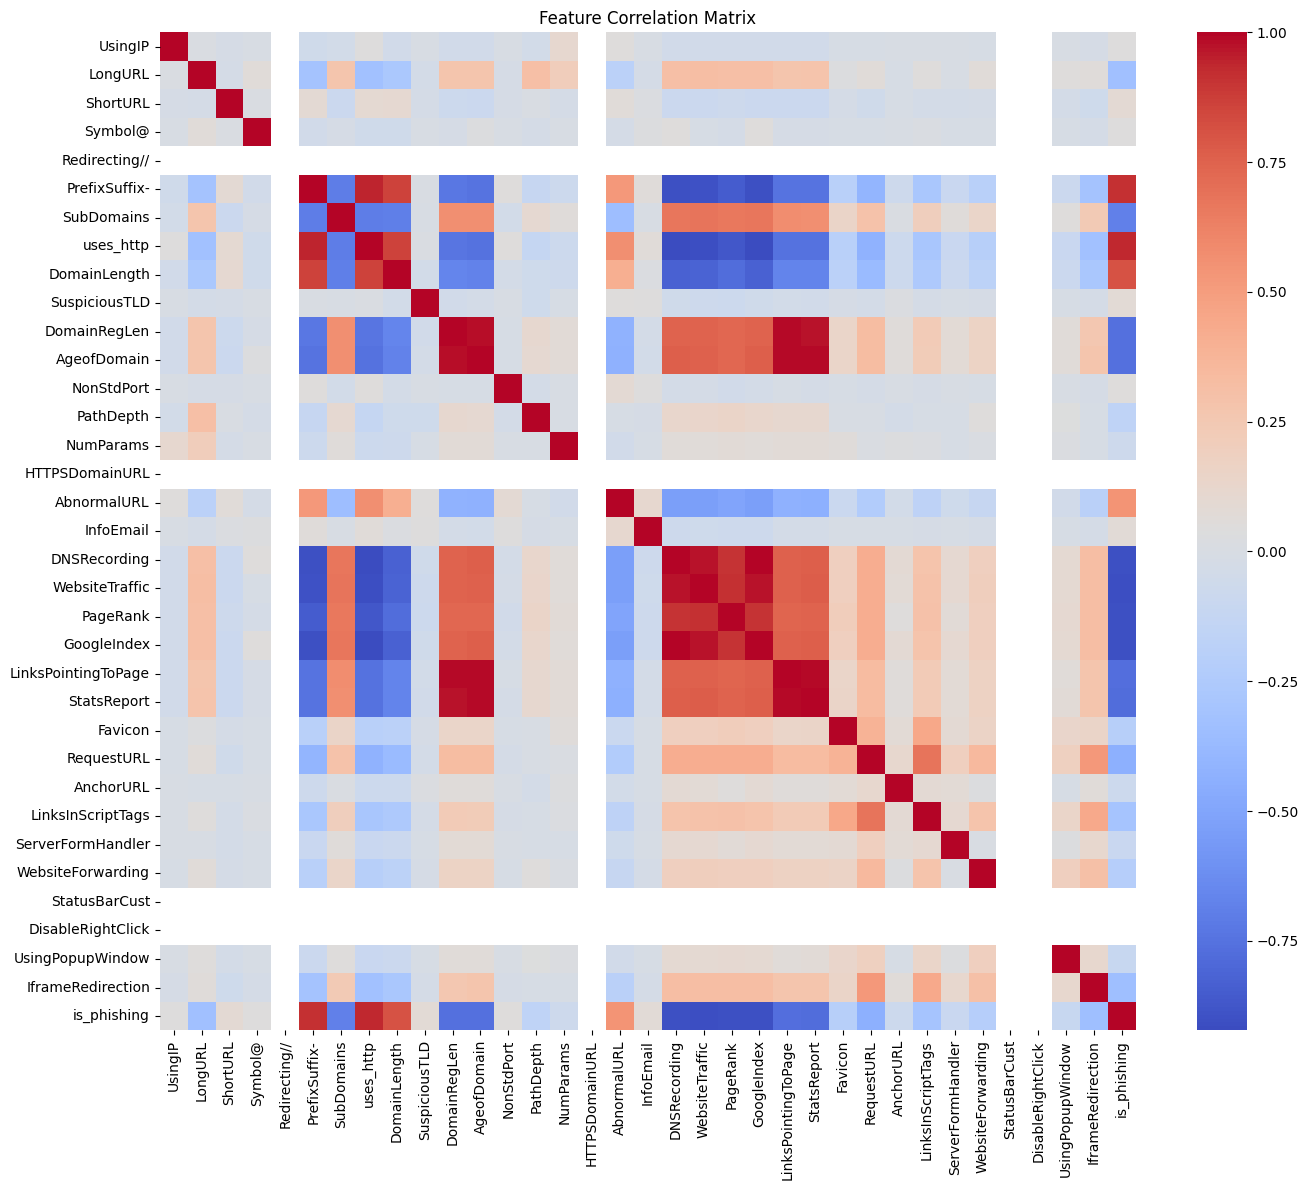

In [32]:
plt.figure(figsize=(14, 12))
sns.heatmap(features_df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Model Training

In [33]:
log_event("MODEL_TRAINING", "Starting model training with Random Forest")
start_time = time.time()

[2025-04-29T12:59:31.934461] MODEL_TRAINING: Starting model training with Random Forest


### Prepare features and target

In [34]:
X = features_df.drop('is_phishing', axis=1)
y = features_df['is_phishing']

### Split data (80% train, 20% test)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Log the data split information

In [36]:
log_event("DATA_SPLIT", "Data split into training and testing sets",
          {"train_samples": X_train.shape[0], "test_samples": X_test.shape[0]})

[2025-04-29T12:59:36.187984] DATA_SPLIT: Data split into training and testing sets


### Feature scaling

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Compute class weights for imbalanced classes

In [38]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.ones(len(y_train))
for idx, label in enumerate(np.unique(y_train)):
    sample_weights[y_train == label] = class_weights[idx]

### Train Random Forest Model

In [39]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=15,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

In [40]:
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, min_samples_split=15,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [41]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-04-29T12:59:44.478043] TIMING: Model training completed in 12.54 seconds


## 6. Model Evaluation

In [42]:
log_event("MODEL_EVALUATION", "Evaluating Random Forest model")
start_time = time.time()

[2025-04-29T12:59:46.047662] MODEL_EVALUATION: Evaluating Random Forest model


### Make predictions

In [43]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

### Calculate metrics

In [44]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

### ROC curve and AUC

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

### Log the evaluation metrics

In [46]:
log_event("EVALUATION_METRICS", "Model performance metrics", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc)
})

[2025-04-29T12:59:51.936034] EVALUATION_METRICS: Model performance metrics


In [47]:
print("\nModel Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


Model Performance:
Accuracy: 0.9850
Precision: 0.9826
Recall: 0.9875
F1 Score: 0.9850
AUC: 0.9971


### Plot confusion matrix

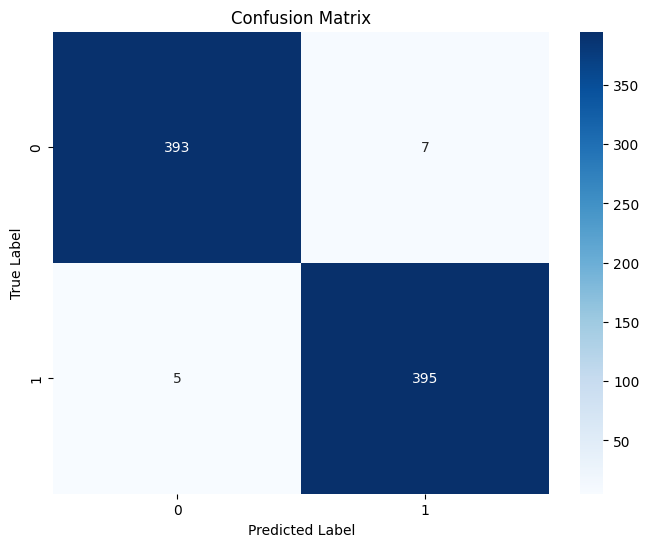

In [48]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Plot ROC curve

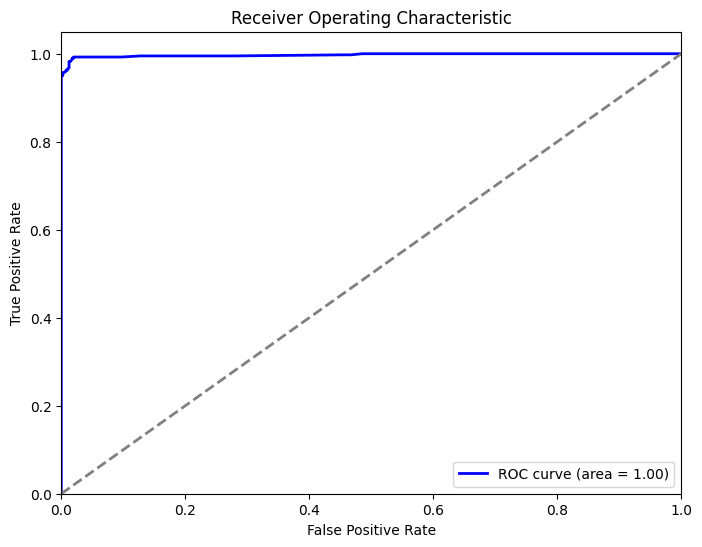

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature importance

In [50]:
feature_importances = pd.DataFrame(
    rf_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

In [51]:
print("\nFeature Importance Distribution:")
print(feature_importances.head(15))


Feature Importance Distribution:
                     importance
uses_http              0.192547
PageRank               0.145351
DNSRecording           0.106453
PrefixSuffix-          0.097387
GoogleIndex            0.093008
WebsiteTraffic         0.084366
DomainLength           0.067339
SubDomains             0.063809
DomainRegLen           0.037861
StatsReport            0.036524
LinksPointingToPage    0.029662
AbnormalURL            0.016191
AgeofDomain            0.012157
RequestURL             0.008101
IframeRedirection      0.002060


### Plot feature importance

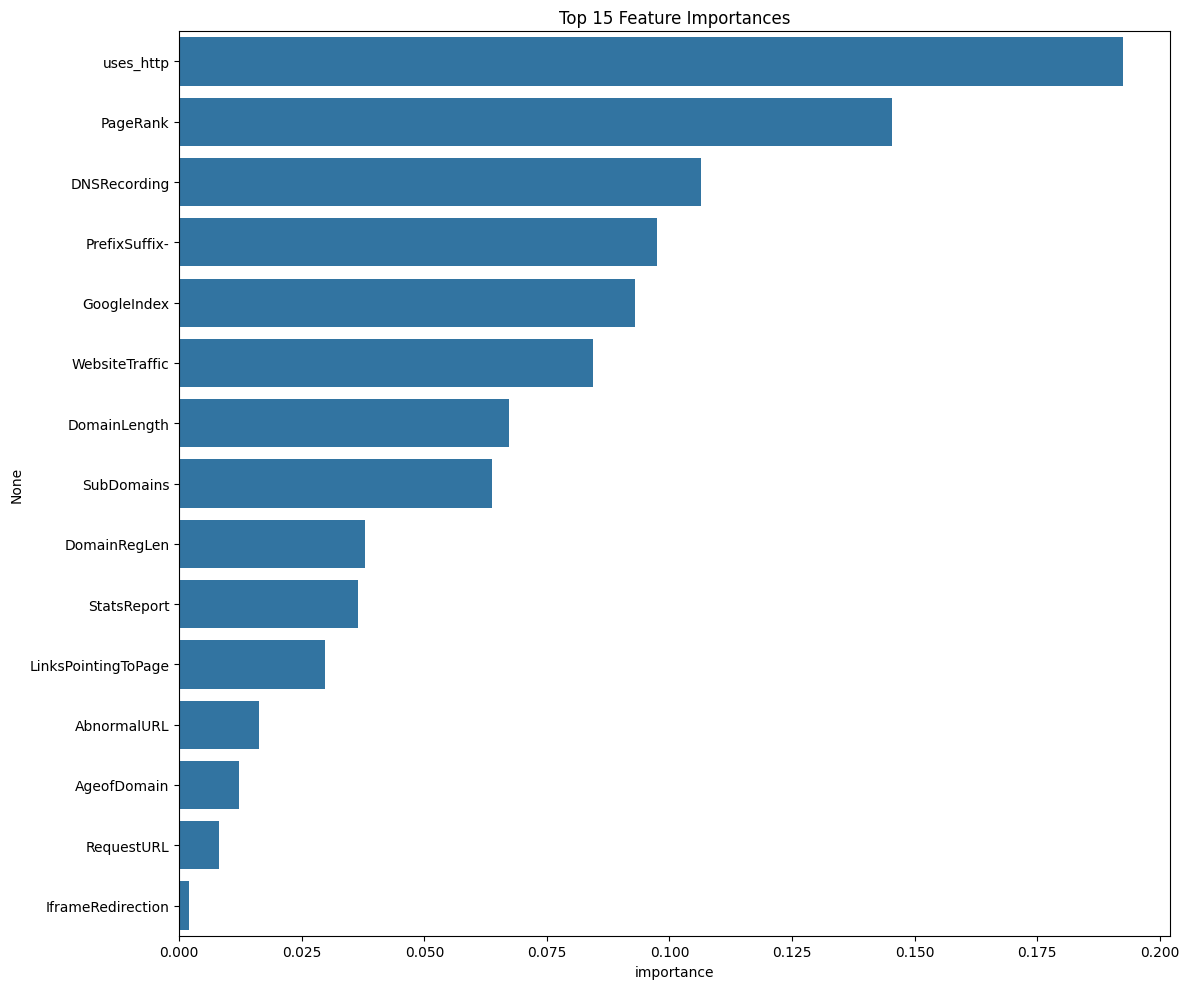

In [52]:
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances['importance'].head(15), y=feature_importances.index[:15])
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [53]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-04-29T13:00:09.214196] TIMING: Model evaluation completed in 23.17 seconds


## 7. Hyperparameter Tuning

In [54]:
log_event("HYPERPARAMETER_TUNING", "Starting hyperparameter tuning")
start_time = time.time()

[2025-04-29T13:00:10.346935] HYPERPARAMETER_TUNING: Starting hyperparameter tuning


### Focused parameter grid based on initial model performance

In [55]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 5, 6]
}

### Subset of data for faster tuning

In [56]:
X_tune = X_train_scaled[:min(1000, X_train_scaled.shape[0])]
y_tune = y_train[:min(1000, y_train.shape[0])]

### Set up cross-validation grid search

In [57]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        max_features='sqrt',
        random_state=42
    ),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

### Run grid search

In [58]:
grid_search.fit(X_tune, y_tune)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='f1')

In [59]:
tuning_time = time.time() - start_time
log_event("TIMING", f"Hyperparameter tuning completed in {tuning_time:.2f} seconds")

[2025-04-29T13:00:39.728949] TIMING: Hyperparameter tuning completed in 29.38 seconds


### Log the best parameters

In [60]:
log_event("HYPERPARAMETER_TUNING", "Best parameters found", {
    "parameters": grid_search.best_params_,
    "f1_score": float(grid_search.best_score_)
})

[2025-04-29T13:00:41.170030] HYPERPARAMETER_TUNING: Best parameters found


In [61]:
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")


Best Parameters:
max_depth: 8
min_samples_leaf: 4
min_samples_split: 20
n_estimators: 200
Best F1 Score: 0.9772


### Final model with the best parameters (on full training data)

In [65]:
final_model = RandomForestClassifier(
    max_features='sqrt',
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

In [66]:
final_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=20,
                       n_estimators=200, n_jobs=-1, random_state=42)

### Evaluate final model

In [67]:
final_pred = final_model.predict(X_test_scaled)
final_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)
final_fpr, final_tpr, _ = roc_curve(y_test, final_pred_proba)
final_auc = auc(final_fpr, final_tpr)

In [68]:
log_event("FINAL_MODEL_EVALUATION", "Final model performance after tuning", {
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1),
    "auc": float(final_auc)
})

[2025-04-29T13:02:08.377287] FINAL_MODEL_EVALUATION: Final model performance after tuning


In [69]:
print("\nFinal Model Performance After Tuning:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"AUC: {final_auc:.4f}")


Final Model Performance After Tuning:
Accuracy: 0.9850
Precision: 0.9826
Recall: 0.9875
F1 Score: 0.9850
AUC: 0.9971


### Confusion matrix for final model

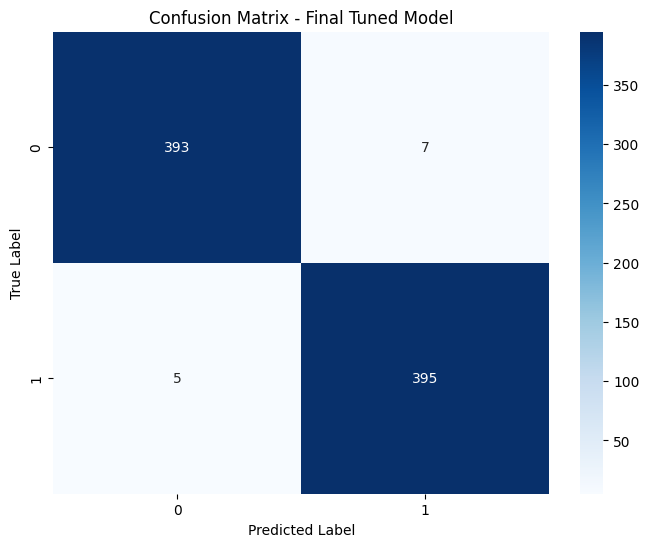

In [70]:
plt.figure(figsize=(8, 6))
final_cm = confusion_matrix(y_test, final_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Tuned Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC curve for final model

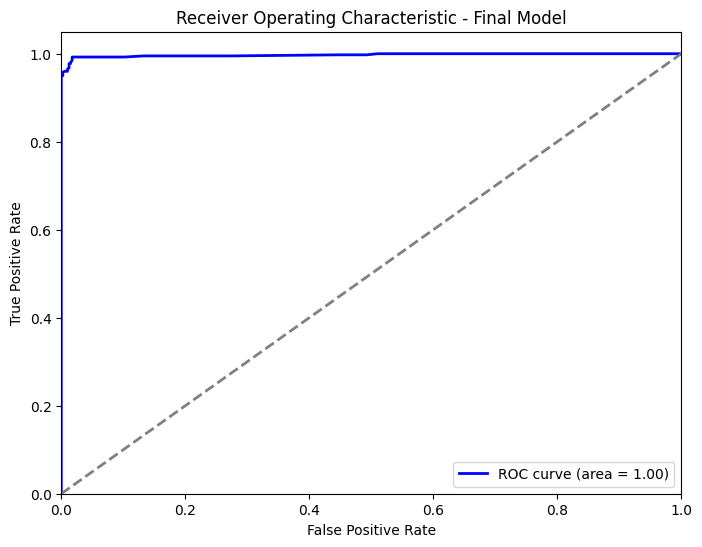

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(final_fpr, final_tpr, color='blue', lw=2, label=f'ROC curve (area = {final_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Final Model')
plt.legend(loc="lower right")
plt.show()

### Feature importance for final model

In [72]:
final_feature_importances = pd.DataFrame(
    final_model.feature_importances_,
    index=X.columns,
    columns=['importance']
).sort_values('importance', ascending=False)

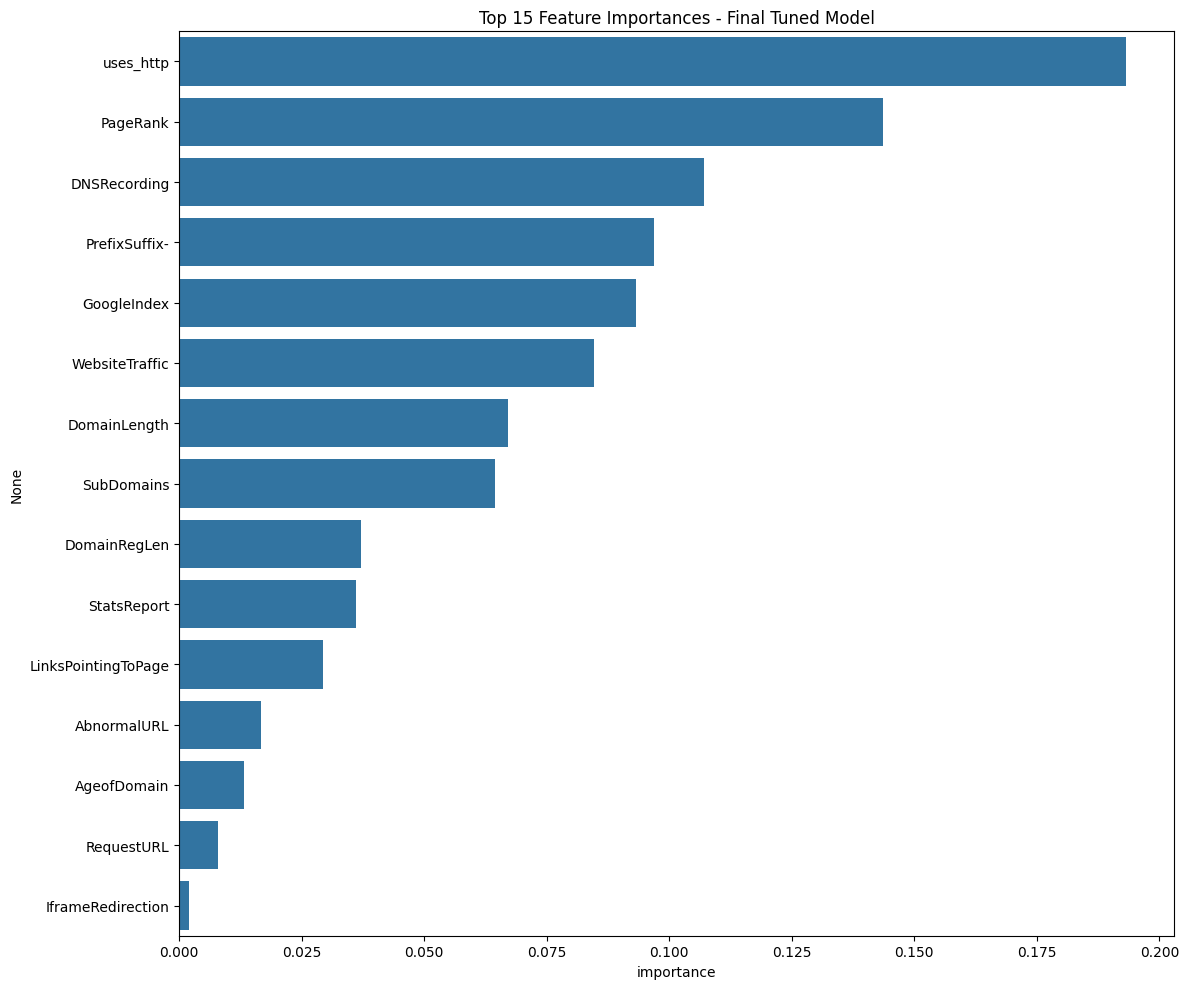

In [73]:
plt.figure(figsize=(12, 10))
sns.barplot(x=final_feature_importances['importance'].head(15), y=final_feature_importances.index[:15])
plt.title('Top 15 Feature Importances - Final Tuned Model')
plt.tight_layout()
plt.show()

## 8. Testing with Real-World URLs

In [74]:
log_event("MODEL_TESTING", "Testing final model with comprehensive URL test cases")

[2025-04-29T13:02:22.761619] MODEL_TESTING: Testing final model with comprehensive URL test cases


In [75]:
def test_url(url, model, scaler):
    """Test a single URL with the trained model"""
    features = extract_url_features(url)
    features_df = pd.DataFrame([features])
    features_scaled = scaler.transform(features_df)
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0, 1]  # Probability of being phishing
    return prediction, probability, features

### Test legitimate sites

In [76]:
legitimate_urls = [
    # Major tech companies
    "https://www.google.com",
    "https://www.microsoft.com",
    "https://www.apple.com",
    "https://www.amazon.com",
    "https://www.facebook.com",

    # Non-HTTPS but legitimate - critical test cases
    "http://example.com",
    "http://info.cern.ch" # First ever website
]

In [77]:
print("\n==== Testing Known Legitimate URLs ====")
legitimate_results = []
for url in legitimate_urls:
    try:
        prediction, probability, features = test_url(url, final_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 1 else "✅ CORRECT"

        result = {
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status,
            "key_features": {
                "uses_http": features['uses_http'],
                "SubDomains": features['SubDomains'],
                "DomainRegLen": features['DomainRegLen']
            }
        }
        legitimate_results.append(result)

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: uses_http={features['uses_http']}, SubDomains={features['SubDomains']}, DomainRegLen={features['DomainRegLen']}")

    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Known Legitimate URLs ====

URL: https://www.google.com
Prediction: Legitimate
Phishing Probability: 0.0252
Status: ✅ CORRECT
Key Features: uses_http=0, SubDomains=1, DomainRegLen=1

URL: https://www.microsoft.com
Prediction: Legitimate
Phishing Probability: 0.0136
Status: ✅ CORRECT
Key Features: uses_http=0, SubDomains=1, DomainRegLen=1

URL: https://www.apple.com
Prediction: Legitimate
Phishing Probability: 0.0252
Status: ✅ CORRECT
Key Features: uses_http=0, SubDomains=1, DomainRegLen=1

URL: https://www.amazon.com
Prediction: Legitimate
Phishing Probability: 0.0252
Status: ✅ CORRECT
Key Features: uses_http=0, SubDomains=1, DomainRegLen=1

URL: https://www.facebook.com
Prediction: Legitimate
Phishing Probability: 0.0175
Status: ✅ CORRECT
Key Features: uses_http=0, SubDomains=1, DomainRegLen=1


2025-04-29 13:02:52,669 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 111] Connection refused
ERROR:whois.whois:Error trying to connect to socket: closing socket - [Errno 111] Connection refused



URL: http://example.com
Prediction: Legitimate
Phishing Probability: 0.4552
Status: ✅ CORRECT
Key Features: uses_http=1, SubDomains=0, DomainRegLen=1

URL: http://info.cern.ch
Prediction: Phishing
Phishing Probability: 0.5215
Status: ❌ MISCLASSIFIED
Key Features: uses_http=1, SubDomains=1, DomainRegLen=0


### Calculate accuracy on legitimate URLs

In [78]:
legitimate_accuracy = sum(1 for r in legitimate_results if r["status"] == "✅ CORRECT") / len(legitimate_results)
print(f"\nAccuracy on legitimate URLs: {legitimate_accuracy:.2%}")


Accuracy on legitimate URLs: 85.71%


### Test known phishing patterns

In [79]:
phishing_patterns = [
    # Brand impersonation with subdomains
    "https://paypal.secure.phishing-site.com/login",
    "https://verification-apple.account-info.net/signin",
    "https://accounts.google.verification.loginauth.net/signin",

    # Typosquatting
    "https://www.arnazon.com/signin",
    "https://www.micro-soft.com/login",
    "https://www.gooogle.com/accounts",

    # Suspicious parameters and paths
    "https://legitimate-looking.com/login.php?target=paypal&session=expired",
    "https://banking-secure.phish.org/verification/customer/login.html?ref=urgent",

    # IP addresses in URL
    "http://192.168.1.1/banking/login",
    "https://123.45.67.89/signin/verification",

    # Uncommon TLDs with suspicious paths
    "https://banking-secure.xyz/verify-now",
    "https://account-update.top/secure-signin"
]

In [80]:
print("\n==== Testing Phishing URL Patterns ====")
phishing_results = []
for url in phishing_patterns:
    try:
        prediction, probability, features = test_url(url, final_model, scaler)
        status = "❌ MISCLASSIFIED" if prediction == 0 else "✅ CORRECT"

        result = {
            "url": url,
            "prediction": prediction,
            "probability": probability,
            "status": status,
            "key_features": {
                "uses_http": features['uses_http'],
                "SubDomains": features['SubDomains'],
                "AbnormalURL": features['AbnormalURL']
            }
        }
        phishing_results.append(result)

        print(f"\nURL: {url}")
        print(f"Prediction: {'Phishing' if prediction == 1 else 'Legitimate'}")
        print(f"Phishing Probability: {probability:.4f}")
        print(f"Status: {status}")
        print(f"Key Features: uses_http={features['uses_http']}, AbnormalURL={features['AbnormalURL']}, SubDomains={features['SubDomains']}")
    except Exception as e:
        print(f"Error analyzing {url}: {str(e)}")


==== Testing Phishing URL Patterns ====

URL: https://paypal.secure.phishing-site.com/login
Prediction: Phishing
Phishing Probability: 0.7442
Status: ✅ CORRECT
Key Features: uses_http=0, AbnormalURL=1, SubDomains=2

URL: https://verification-apple.account-info.net/signin
Prediction: Phishing
Phishing Probability: 0.7427
Status: ✅ CORRECT
Key Features: uses_http=0, AbnormalURL=1, SubDomains=1

URL: https://accounts.google.verification.loginauth.net/signin
Prediction: Legitimate
Phishing Probability: 0.4973
Status: ❌ MISCLASSIFIED
Key Features: uses_http=0, AbnormalURL=1, SubDomains=3

URL: https://www.arnazon.com/signin
Prediction: Legitimate
Phishing Probability: 0.2518
Status: ❌ MISCLASSIFIED
Key Features: uses_http=0, AbnormalURL=1, SubDomains=1

URL: https://www.micro-soft.com/login
Prediction: Legitimate
Phishing Probability: 0.3562
Status: ❌ MISCLASSIFIED
Key Features: uses_http=0, AbnormalURL=1, SubDomains=1

URL: https://www.gooogle.com/accounts
Prediction: Legitimate
Phishing 

### Calculate accuracy on phishing URLs

In [81]:
phishing_accuracy = sum(1 for r in phishing_results if r["status"] == "✅ CORRECT") / len(phishing_results)
print(f"\nAccuracy on phishing URLs: {phishing_accuracy:.2%}")


Accuracy on phishing URLs: 58.33%


### Overall testing statistics

In [82]:
print("\n==== Overall Testing Results ====")
all_results = legitimate_results + phishing_results
overall_accuracy = sum(1 for r in all_results if r["status"] == "✅ CORRECT") / len(all_results)
print(f"Overall accuracy: {overall_accuracy:.2%}")


==== Overall Testing Results ====
Overall accuracy: 68.42%


### Log test results

In [83]:
log_event("MODEL_TESTING_RESULTS", "Results of comprehensive URL testing", {
    "legitimate_url_accuracy": float(legitimate_accuracy),
    "phishing_url_accuracy": float(phishing_accuracy),
    "overall_accuracy": float(overall_accuracy),
    "legitimate_urls_tested": len(legitimate_results),
    "phishing_urls_tested": len(phishing_results)
})

[2025-04-29T13:04:06.436393] MODEL_TESTING_RESULTS: Results of comprehensive URL testing


## 9. Save Model and Artifacts

In [84]:
log_event("MODEL_SAVING", "Saving final model and artifacts")
start_time = time.time()

[2025-04-29T13:04:07.895751] MODEL_SAVING: Saving final model and artifacts


### Save the models

In [85]:
joblib.dump(final_model, MODEL_OUTPUT_PATH)
joblib.dump(scaler, SCALER_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/chatbot/chatbot_scaler.pkl']

### Save feature names for inference

In [86]:
with open(FEATURES_OUTPUT_PATH, 'w') as f:
    json.dump(list(X.columns), f)

### Save model parameters and metadata

In [87]:
model_info = {
    "name": "chatbot_random_forest_model",
    "type": "random_forest",
    "version": "1.0",
    "trained_at": datetime.now().isoformat(),
    "accuracy": float(final_accuracy),
    "precision": float(final_precision),
    "recall": float(final_recall),
    "f1_score": float(final_f1),
    "auc": float(final_auc),
    "parameters": {
        "n_estimators": final_model.n_estimators,
        "max_depth": final_model.max_depth,
        "min_samples_split": final_model.min_samples_split,
        "min_samples_leaf": final_model.min_samples_leaf,
        "max_features": str(final_model.max_features)
    },
    "feature_importances": {
        name: float(importance) for name, importance in
        zip(final_feature_importances.index, final_feature_importances['importance'])
    },
    "dataset_size": df.shape[0],
    "training_samples": X_train.shape[0],
    "test_samples": X_test.shape[0],
    "features_implemented": list(X.columns)
}

In [88]:
with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(model_info, f, indent=2)

### Save all logs to file

In [89]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-04-29T13:04:21.946849] TIMING: Model saving completed in 14.05 seconds


In [90]:
def save_logs_with_append(log_data, log_file_path):
    try:
        with open(log_file_path, 'r') as f:
            try:
                existing_logs = json.load(f)
                if not isinstance(existing_logs, list):
                    existing_logs = []
            except json.JSONDecodeError:
                existing_logs = []
    except FileNotFoundError:
        existing_logs = []

    combined_logs = existing_logs + log_data

    with open(log_file_path, 'w') as f:
        json.dump(combined_logs, f, indent=2)

    print(f"Appended {len(log_data)} new log entries to {log_file_path}")
    return combined_logs

In [91]:
combined_logs = save_logs_with_append(log_data, LOG_OUTPUT_PATH)

Appended 22 new log entries to /content/drive/MyDrive/PUSL3190/logs/chatbot_training_log.json


In [92]:
print("\n===== TRAINING COMPLETE =====")
print(f"Final model accuracy: {final_accuracy:.4f}")
print(f"Model saved to {MODEL_OUTPUT_PATH}")
print(f"Logs saved to {LOG_OUTPUT_PATH}")


===== TRAINING COMPLETE =====
Final model accuracy: 0.9850
Model saved to /content/drive/MyDrive/PUSL3190/models/chatbot/chatbot_model.pkl
Logs saved to /content/drive/MyDrive/PUSL3190/logs/chatbot_training_log.json
